# Machine Learning For NLP : Prediction of Gender

# Table des matières

* [0. Imports et Packages](#chapter0)
* [1. Nettoyage des données](#chapter1)
* [2. Statistiques descriptives](#statdesc)
* [3. Preprocessing](#preprocessing)
* [4. Modélisation](#modelisation)  
  * [4.1 Modèle naïf](#modelenaif)
  * [4.2 Modèle : Bert Base Uncased](#bert)
  * [4.3 Modèle : Camembert base](#camembert)
  * [4.4 Modèle : DistilBERT](#distilbert)
  * [4.5 Données réduites](#donnees-réduites)


## 0. Imports et Packages <a class="anchor" id='chapter0'></a>

In [3]:
import numpy as np
import pandas as pd
import re
from functions import cleaning_pipeline, concatenate_column_names, train_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from functions import calculate_scores
# Importing necessary libraries
import torch
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    AdamW,
)
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# Mettre les données dans le même répertoires que le notebook
df = pd.read_csv("transcriptions_with_sex.csv")
name_data = pd.read_csv("firstname_with_sex.csv", sep=";")

In [5]:
name_data.columns = ["prénom", "nombre hommes", "nombre femmes"]
name_data.head()

,prénom,nombre hommes,nombre femmes
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047
3,jeanne,1765,1097397
4,françois,1089009,5951


## 1. Nettoyage des données <a class="anchor" id="chapter1"></a>

In [6]:
column_to_extract = "prediction"
columns_to_drop = ["subject_line", "groundtruth"]
cleaned_df = cleaning_pipeline(df, name_data, column_to_extract, columns_to_drop)

In [7]:
#On drop les observations où le sexe est ambigu
cleaned_df = cleaned_df[cleaned_df["sex"] != "ambigu"]

In [8]:
# Séparation des features (X) et de la cible (y)
X = cleaned_df.drop("sex", axis=1)  # Features (toutes les colonnes sauf 'sex')
y = cleaned_df["sex"]  # Cible (colonne 'sex')

# Split initial en train/validation + test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split du train/validation en train + validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.2,
    random_state=42,
    stratify=y_train_val,
)

# Affichage des tailles des ensembles
print("Taille de l'ensemble d'entraînement :", len(X_train))
print("Taille de l'ensemble de validation :", len(X_val))
print("Taille de l'ensemble de test :", len(X_test))

Taille de l'ensemble d'entraînement : 148
Taille de l'ensemble de validation : 37
Taille de l'ensemble de test : 47


In [9]:
# Compter le nombre de NaN par colonne
na_counts = X_train.isna().sum()

# Afficher le nombre de NaN par colonne
print(na_counts)

relation            59
prénom               0
date_naissance       1
profession         109
état_civil         123
lieux_naissance     38
nom                  7
employeur          124
éducation          147
nombre hommes       13
nombre femmes       13
dtype: int64


## 2. Statistiques descriptives <a id='statdesc'></a>

### 2.1 Wordcloud sur la fréquence des genres des prénoms

In [10]:
name_data["female_freq"] = name_data["nombre femmes"] / (name_data["nombre hommes"] + name_data["nombre femmes"])

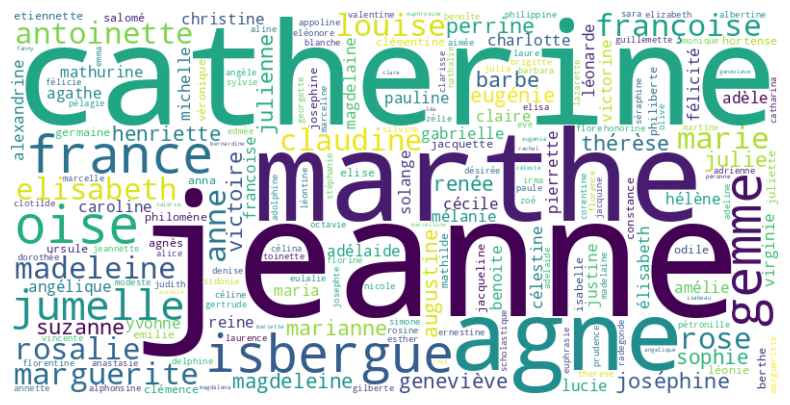

In [11]:
most_female_name = name_data[name_data["female_freq"] >= 0.5]
all_names = " ".join(most_female_name["prénom"].dropna())
wordcloud = WordCloud(
    width=800, height=400, background_color="white"
).generate(all_names)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off") 
#plt.title("Nuage de mots des prénoms le plus souvent féminin")
plt.show()

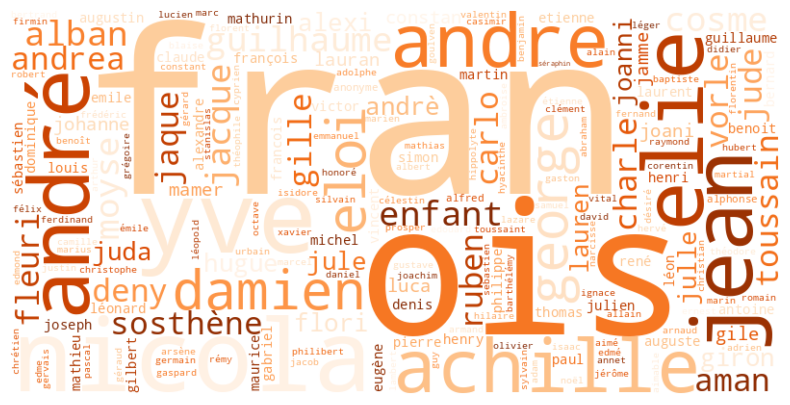

In [12]:
most_male_name = name_data[name_data["female_freq"] < 0.5]
all_names = " ".join(most_male_name["prénom"].dropna())
colormap = "Oranges"
wordcloud = WordCloud(
    width=800, height=400, background_color="white", colormap=colormap
).generate(all_names)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#plt.title("Nuage de mots des prénoms le plus souvent masculin")
plt.show()

### 2.2 Statistiques descriptives sur le données d'entraînements

In [13]:
df_train = X_train.copy()
df_train['target'] = y_train
df_homme = df_train[df_train['target'] == 'homme']  
df_femme = df_train[df_train["target"] == "femme"]

In [14]:
for col in df_train.columns:
    value_counts = df_train[col].value_counts()
    print(f"Value counts pour la colonne '{col}':\n{value_counts}\n")

Value counts pour la colonne 'relation':
chef          15
id             6
fils           4
F              4
enfant         3
Ch             3
sans           3
Ep             2
C              2
d              2
Chef           2
belle          2
femme          2
ch             2
a              1
fimme          1
employée       1
ép             1
io             1
inf            1
f              1
cullinière     1
argentière     1
chausne        1
domestique     1
noant          1
fomme          1
couturière     1
epre           1
frère          1
Rouher         1
fille          1
chemin         1
noraise        1
camprof        1
ouvrier        1
p              1
B              1
bent           1
petite         1
cultinière     1
Gonde          1
se             1
prof           1
chacon         1
Empl           1
Emp            1
sa             1
fins           1
coms           1
P              1
Name: relation, dtype: int64

Value counts pour la colonne 'prénom':
marie         18
jean  

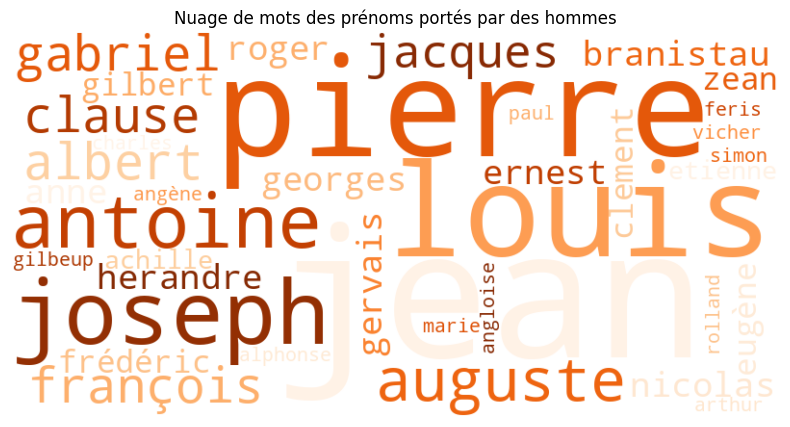

In [15]:
all_names = " ".join(df_homme["prénom"].dropna())
colormap = "Oranges"
wordcloud = WordCloud(
    width=800, height=400, background_color="white", colormap=colormap
).generate(all_names)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots des prénoms portés par des hommes")
plt.show()

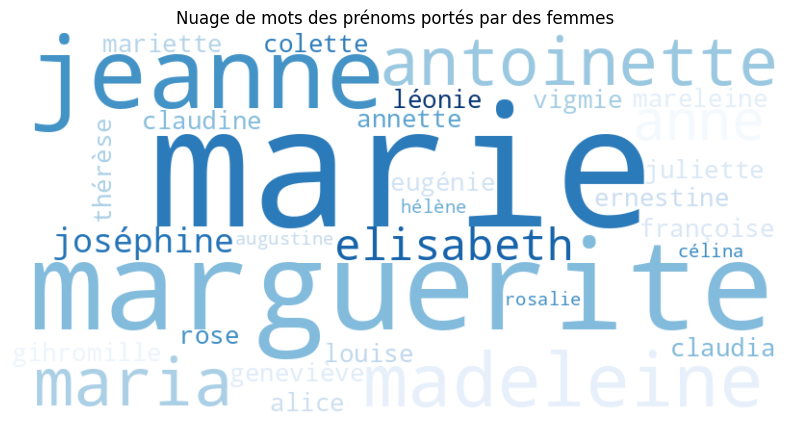

In [16]:
all_names = " ".join(df_femme["prénom"].dropna())
colormap = "Blues"
wordcloud = WordCloud(
    width=800, height=400, background_color="white", colormap=colormap
).generate(all_names)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots des prénoms portés par des femmes")
plt.show()

## 3. Preprocessing <a id='preprocessing'></a>

In [16]:
# Données réduites où on ne prend que le nom et le prénom dans la chaine de caractères
X_train_reduced = X_train[["prénom", "nom"]]
X_val_reduced = X_val[["prénom", "nom"]]
X_test_reduced = X_test[["prénom", "nom"]]

In [17]:
# Données entières reconcaténées 
X_train['texte'] = X_train.apply(concatenate_column_names, axis=1)
X_val["texte"] = X_val.apply(concatenate_column_names, axis=1)
X_test["texte"] = X_test.apply(concatenate_column_names, axis=1)

X_train_reduced["texte"] = X_train_reduced.apply(
    concatenate_column_names, axis=1
)
X_val_reduced["texte"] = X_val_reduced.apply(concatenate_column_names, axis=1)
X_test_reduced["texte"] = X_test_reduced.apply(
    concatenate_column_names, axis=1
)

/Users/emanieluu/Documents/ENSAE/3A/S2/NLP/nlp_project/ml_for_nlp/preprocessing.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, value in row.iteritems():
/Users/emanieluu/Documents/ENSAE/3A/S2/NLP/nlp_project/ml_for_nlp/preprocessing.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, value in row.iteritems():
/Users/emanieluu/Documents/ENSAE/3A/S2/NLP/nlp_project/ml_for_nlp/preprocessing.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, value in row.iteritems():
/Users/emanieluu/Documents/ENSAE/3A/S2/NLP/nlp_project/ml_for_nlp/preprocessing.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, value in row.iteritems():
/var/folders/ts/w88f9trn42770xnr2_s8nchh0000gn/T/ipykernel_21921/4258509290.py:5: Se

## 4. Modélisation <a id='modelisation'></a>

### 4.1 Modèle naïf <a id='modelenaif'></a>


In [19]:
y_predict_train = pd.Series(
    [
        "homme" if male > female else "femme"
        for male, female in zip(X_train["nombre hommes"], X_train["nombre femmes"])
    ]
)

y_predict_test = pd.Series(
    [
        "homme" if male > female else "femme"
        for male, female in zip(X_test["nombre hommes"], X_test["nombre femmes"])
    ]
)

In [20]:
y_predict_test.isna().sum()

0

In [21]:
# Calcul des scores pour les prédictions sur l'ensemble d'entraînement (train)
train_scores_df = calculate_scores(y_train, y_predict_train, label="homme")

# Calcul des scores pour les prédictions sur l'ensemble de test (test)
test_scores_df = calculate_scores(y_test, y_predict_test, label="homme")

# Concaténation des dataframes de scores
final_scores_df = pd.concat(
    [train_scores_df, test_scores_df], keys=["Train", "Test"]
)

# Affichage du dataframe des scores
print(final_scores_df)

             Accuracy  Precision  Recall  F1 Score
Train homme  0.918919        1.0    0.85  0.918919
Test  homme  0.936170        1.0    0.88  0.936170


### 4.2 Modèle : Bert Base Uncased <a id='bert'></a>

In [22]:
# Division des données en ensembles d'entraînement et de validation
train_texts = X_train['texte'].tolist()
val_texts = X_val["texte"].tolist()
test_texts = X_test['texte'].tolist()

# Conversion des cibles en labels numériques (0 pour femme, 1 pour homme)
train_targets = y_train.apply(lambda x: 1 if x == "homme" else 0).tolist()
val_targets = y_val.apply(lambda x: 1 if x == "homme" else 0).tolist()
test_targets = y_test.apply(lambda x: 1 if x == "homme" else 0).tolist()

In [23]:
train_model(
    X_train,
    X_val,
    X_test,
    train_targets,
    val_targets,
    test_targets,
    model_type="bert",
    num_epochs=4,
    learning_rate=2e-5,
    batch_size=16,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/emanieluu/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Average training loss = 0.6889
Epoch 1: Validation accuracy = 0.7568
Epoch 2: Average training loss = 0.6624
Epoch 2: Validation accuracy = 0.5405
Epoch 3: Average training loss = 0.5321
Epoch 3: Validation accuracy = 0.8649
Epoch 4: Average training loss = 0.2883
Epoch 4: Validation accuracy = 0.9189
Final Test accuracy: 0.9787
Final Test F1 score: 0.9804


### 4.3 Modèle : Camembert base <a id='camembert'></a>

In [24]:
train_model(
    X_train,
    X_val,
    X_test,
    train_targets,
    val_targets,
    test_targets,
    model_type="camembert",
    num_epochs=6,
    learning_rate=2e-5,
    batch_size=16,
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/emanieluu/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Average training loss = 0.6941
Epoch 1: Validation accuracy = 0.5405
Epoch 2: Average training loss = 0.6850
Epoch 2: Validation accuracy = 0.5405
Epoch 3: Average training loss = 0.6735
Epoch 3: Validation accuracy = 0.6757
Epoch 4: Average training loss = 0.6271
Epoch 4: Validation accuracy = 0.8919
Epoch 5: Average training loss = 0.5210
Epoch 5: Validation accuracy = 0.8919
Epoch 6: Average training loss = 0.3377
Epoch 6: Validation accuracy = 0.8649
Final Test accuracy: 0.9362
Final Test F1 score: 0.9434


### 4.3 Modèle : DistilBERT <a id='distilbert'></a>

In [25]:
train_model(
    X_train,
    X_val,
    X_test,
    train_targets,
    val_targets,
    test_targets,
    model_type="distilbert",
    num_epochs=4,
    learning_rate=2e-5,
    batch_size=16,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/emanieluu/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Average training loss = 0.7109
Epoch 1: Validation accuracy = 0.5405
Epoch 2: Average training loss = 0.6831
Epoch 2: Validation accuracy = 0.5946
Epoch 3: Average training loss = 0.6572
Epoch 3: Validation accuracy = 0.6216
Epoch 4: Average training loss = 0.5380
Epoch 4: Validation accuracy = 0.7838
Final Test accuracy: 0.8085
Final Test F1 score: 0.8475


### 4.5 Données réduites <a id='données-reduites'></a>

In [26]:
train_model(
    X_train_reduced,
    X_val_reduced,
    X_test_reduced,
    train_targets,
    val_targets,
    test_targets,
    model_type="bert",
    num_epochs=4,
    learning_rate=2e-5,
    batch_size=16,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/emanieluu/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Average training loss = 0.6907
Epoch 1: Validation accuracy = 0.5405
Epoch 2: Average training loss = 0.6688
Epoch 2: Validation accuracy = 0.8108
Epoch 3: Average training loss = 0.5490
Epoch 3: Validation accuracy = 0.8919
Epoch 4: Average training loss = 0.2735
Epoch 4: Validation accuracy = 0.8919
Final Test accuracy: 0.8936
Final Test F1 score: 0.9091


In [27]:
train_model(
    X_train_reduced,
    X_val_reduced,
    X_test_reduced,
    train_targets,
    val_targets,
    test_targets,
    model_type="camembert",
    num_epochs=4,
    learning_rate=2e-5,
    batch_size=16,
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/emanieluu/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Average training loss = 0.6961
Epoch 1: Validation accuracy = 0.5405
Epoch 2: Average training loss = 0.6848
Epoch 2: Validation accuracy = 0.5405
Epoch 3: Average training loss = 0.6632
Epoch 3: Validation accuracy = 0.8649
Epoch 4: Average training loss = 0.5788
Epoch 4: Validation accuracy = 0.8649
Final Test accuracy: 0.9149
Final Test F1 score: 0.9259


In [28]:
train_model(
    X_train_reduced,
    X_val_reduced,
    X_test_reduced,
    train_targets,
    val_targets,
    test_targets,
    model_type="distilbert",
    num_epochs=3,
    learning_rate=2e-5,
    batch_size=16,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/emanieluu/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Average training loss = 0.6856
Epoch 1: Validation accuracy = 0.9189
Epoch 2: Average training loss = 0.5173
Epoch 2: Validation accuracy = 0.9189
Epoch 3: Average training loss = 0.2501
Epoch 3: Validation accuracy = 0.8919
Final Test accuracy: 0.8723
Final Test F1 score: 0.8929
